# ASSIGNMENT 3- Pip Benjamin

## Part 1

The first part of this assignment aims to create a GPU accelerated implementation of the discrete modified Helmholtz problem: 
$$
-\Delta u + \omega^2 u = f
$$

for $u\in [0, 1]^2$. We define a matrix vector product of the form $Ax = b$, where $x$ is a vector of dimension $(N-2)^2$ containing all interior points $u_{i, j}$ for $0 < i, j < N$, $A$ is an operator ${A}:\rightarrow \mathbb{R}^{(N-2)^2}\rightarrow\mathbb{R}^{(N-2)^2}$. Here all boundary points in $u$ are explicitly set to zero.

In [1]:
import numpy as np
import numba
from numba import cuda
import math
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve

First we define our GPU accelerated implementation of the discrete Helmholtz problem. This kernel takes as input the vector `vec_in` which represents $x$, and `vec_out`, an empty array in which to write the results. The kernel also takes the dimension $N-2$ and `omega` parameter $\omega$.

We start here by defining a 2D shared array `local_points` in which to store values in the grid that each threadblock will act upon. This grid is of size $(TPB+2)\times(TPB+2)$, where $TPB$ is the number of threads per block in each dimension. Here we choose our blocks to be of size $32\times32$ threads  

Each point in the grid requires 4 adjacent points in order to evaluate the five point stencil. Points on the boundary of each thread block therefore must load in data outside of the block on all 4 sides of the block. Internal points in `local_points` can therefore be read as the points within the block. Boundary values in `local_points` are read in as the data points on each side of the block boundary. This enables all five points in each evaluation of the five point stencil to be read from the shared memory, rather than global memory, theoretically providing an increase in speed.

If our thread is on the edge of the grid, we require that the boundary values in `local_points` on the edge corresponding to that which meets the edge of the grid are zero, as we explicitly set the boundary values in $u$ to zero.

In [2]:
@cuda.jit
def evaluate_discrete_helmholtz(vec_in, vec_out, N_2, omega):
  """Evaluate the discrete modified Helmholtz operator."""

  #shared array in which to load data associated with all points within thread block, 
  #as well as a layer of external values in order to calculate the five point stencil
  local_points = cuda.shared.array((34,34), numba.float32)
  
  #local thread pos
  ti=cuda.threadIdx.x
  tj=cuda.threadIdx.y

  #threadblock dimensions
  dim_i = cuda.blockDim.x
  dim_j = cuda.blockDim.y

  #global pos
  i, j = cuda.grid(2)

  if i >= N_2:
      return
  if j >= N_2:
      return

  #local points in shared memory (i.e the points we want to evaluate)
  li = ti+1
  lj = tj+1

  # Compute the vector index
  k = j * N_2 + i

  #assign points in shared array to corresponding point in input vector
  local_points[li,lj] = vec_in[k]
  
  #block bottom row
  if  tj==TPB-1:
    k_down = (j+1) * N_2 + i
    local_points[li,33] = vec_in[k_down]

  #block top row
  if tj == 0:
    k_up = (j-1) * N_2 + i
    local_points[li,0] = vec_in[k_up]

  #block left column
  if ti==0:
    k_left = j * N_2 + (i-1)
    local_points[0,lj] = vec_in[k_left]
  
  # block right column
  if ti == TPB-1:
    k_right = j * N_2 + (i+1)
    local_points[33,lj] = vec_in[k_right]
  
  #grid edge
  if j == N_2-1:
    local_points[li, lj+1] = numba.float32(0)
  if i == N_2-1:
    local_points[li+1, lj] = numba.float32(0)
  if i==0:
    local_points[li-1, lj] = numba.float32(0)
  if j==0:
    local_points[li,lj-1] = numba.float32(0)
      
  cuda.syncthreads()
  
  #EVALUATE POINTS
  up = local_points[li,lj-1]
  right = local_points[li+1, lj]
  down = local_points[li, lj+1]
  left = local_points[li-1, lj]
  center = local_points[li, lj]
  vec_out[k] = (N_2 +  1)**2 * (numba.float32(4) * center - up - down - left - right) + ((numba.float32(omega)**2) *  center)
  
  cuda.syncthreads()

def eval_gpu(vec_in, N, omega):
  """Evaluate the discrete modified Helmholtz problem on the GPU."""
  N_2=N-2
  nblocks = (N_2 +31) // 32
  TPB=32
  
  res = np.zeros((N_2 * N_2), dtype=np.float32)
  
  evaluate_discrete_helmholtz[(nblocks, nblocks), (TPB, TPB)](vec_in.astype('float32'), res, N_2, omega)
  y_gpu = res
    
  return y_gpu

For comparisson we now define a CPU implementation of the discrete Poisson matrix vector product.

In [3]:
def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f



We now compare our GPU and CPU implementations. Since our CPU implementation computes the result as a vector of size $N^2$, including the result of the operation at the boundary values, explicitly set to zero, we remove all zero elements from our CPU result before comparrison.

In [4]:
N=500
N_2=N-2
TPB=32
omega=0

#set up initial matrix distribution u
u=np.zeros((N,N))
for n in range (1,int(N/2 +1/2)+1):
    u[n:(N-1)-(n-1), n:(N-1)-(n-1)]=n*n

#remove boundary points from u and convert to 1darray for gpu implementation
u_reduce=u[1:(N-1),1:(N-1)] #(N-2)(N-2) matrix
vec_in=np.zeros(N_2*N_2, dtype=np.float32)
for i in range(N_2):
  for j in range(N_2):
    vec_in[j * N_2 + i] =u_reduce[i,j]

#vector containing boundary points for cpu implementation
x=np.zeros(N*N, dtype=np.float32)
for i in range(N):
  for j in range(N):
    x[j * N + i] = u[i,j]

#cpu implement
A, _ = discretise_poisson(N)
y_cpu = A @ x

#gpu implement
y_gpu = eval_gpu(vec_in, N, omega)

#Calculate error between cpu and gpu implementation result arrays, not including zeros assoc with boundary points
rel_error = np.linalg.norm(y_cpu[y_cpu != 0] - y_gpu, np.inf) / np.linalg.norm(y_cpu, np.inf)
print(f"Relative errorr: {rel_error}.")

Relative errorr: 2.424173920515555e-08.


We have found that the error between our CPU and GPU implementations is of the order of machine precission in 32 bit floating point accuracy, since our GPU implementation uses single precission while the CPU implementation uses double precission.

## Benchmarking

We now benchmark our new GPU implementation against that from the previous assignment, which doesn't utilise shared memory.

In [5]:
@cuda.jit
def evaluate_discrete_laplace(vec_in, vec_out, N):
    """Evaluate the discrete Laplace operator."""
    
    i, j = cuda.grid(2)
    
    if i >= N:
        return
    if j >= N:
        return
    
    # Compute the vector index
    k = j * N + i
    
    if i == 0 or i == N - 1 or j == 0 or j == N - 1:
        # We are at the boundary
        # Here, the matrix just acts like the identity
        vec_out[k] = vec_in[k]
        return
    
    # Now deal with the interior element
    
    up = vec_in[(j + 1) * N + i]
    down = vec_in[(j - 1) * N + i]
    left = vec_in[j * N + i - 1]
    right = vec_in[j * N + i + 1]
    center = vec_in[k]
    
    vec_out[k] = (N - 1)**2 * (numba.float32(4) * center - up - down - left - right)
    
def eval_gpu_as2(x, N):
    """Evaluate the discrete Laplacian on the GPU."""
    
    res = np.empty(N * N, dtype=np.float32)
    
    nblocks = (N + 31) // 32
    evaluate_discrete_laplace[(nblocks, nblocks), (32, 32)](x.astype('float32'), res, N)
    return res.astype('float64')

In [6]:
def benchmark(N):
    """Benchmark the Assignment 2 and Assignment 3 GPU implementations."""
    rand = np.random.RandomState(0)
    x = rand.randn(N * N)
    
    print("Assignment 2 Benchmark")
    %timeit y_as2 = eval_gpu_as2(x,N)
    
    print("Assignment 3 Benchmark")
    %timeit y_as3 = eval_gpu(x, N,0)

print("Small size benchmark (n=1000)")
print("----------------------------")
benchmark(1000)
print("Large size benchmark (n=10000)")
print("-------------------------------")
benchmark(10000)

Small size benchmark (n=1000)
----------------------------
Assignment 2 Benchmark
The slowest run took 47.22 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 3 ms per loop
Assignment 3 Benchmark
100 loops, best of 3: 2.74 ms per loop
Large size benchmark (n=10000)
-------------------------------
Assignment 2 Benchmark
100 loops, best of 3: 2.98 ms per loop
Assignment 3 Benchmark
100 loops, best of 3: 2.77 ms per loop


Our benchmarking here shows only a modest speed-up from our non-shared memory utilising implementation to our new implementation, on the order of 0.1ms. Accesses to global memory in our new kernel are limited to once per thread for interior points, and twice per thread for boundary points, as well as one write to global memory for each thread. We then have five accesses to shared memory in order to compute the five point stencil. We can therefore perhaps conclude that the speed-up we see in terms of memory access is modest compared to the time taken for our floating point operations.

## Part 2

In part 2 we wish to wrap our CUDA implementation of the modified Helmholtz problem into a `LinearOperator` object, in order to apply an iterative solver to our linear system of equations $
\tilde{A}x = f,
$ using the Conjugate-Gradients method.

In [7]:
 from scipy.sparse.linalg  import LinearOperator, cg
 %matplotlib inline
from matplotlib import pyplot as plt

In [8]:
def genLinOp(eval_gpu, N, omega):
  """Generate a LinearOperator object associated with the modified Helmholtz function."""
  def matvec(x):
    return eval_gpu(x, N, omega)
  
  return LinearOperator(((N-2)**2,(N-2)**2), matvec = matvec)

Here we plot relative residuals $\|Ax_k-b\|_2/\|b\|_2$ for each iteration of the CG method, for arrays of values of $N$ and $\omega$.

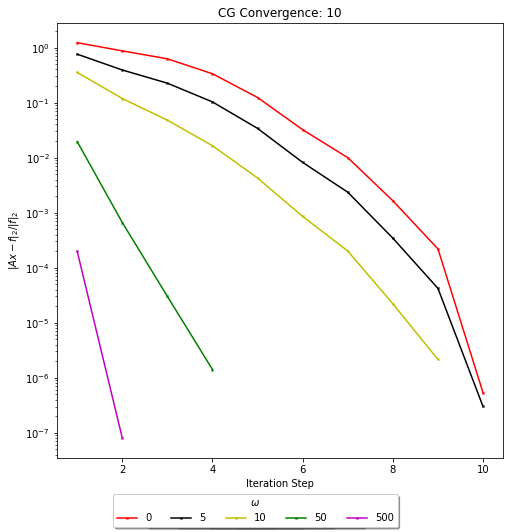

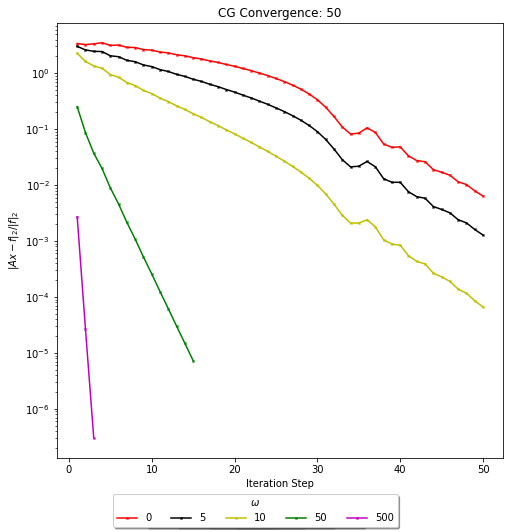

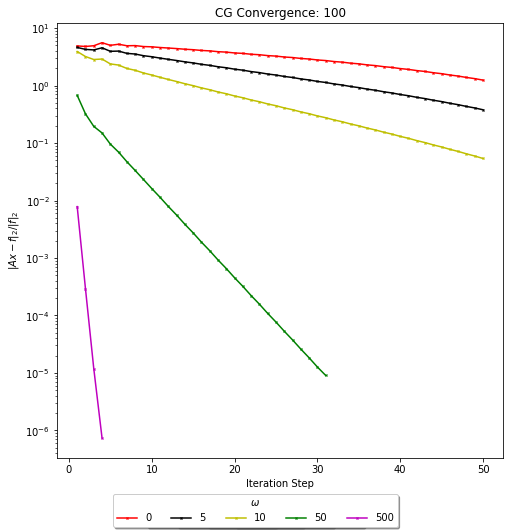

In [9]:
omegas = [0, 5, 10, 50, 500]
colors = ['r', 'k', 'y', 'g', 'm']
Ns= [10,50, 100]

# for our chosen N, omega values
for Ndex, Nval in enumerate(Ns):
  fig = plt.figure(figsize=(8, 8))
  ax = fig.add_subplot(111)
  N=Nval

  for index, omega in enumerate(omegas):
    f=np.ones((N-2)*(N-2))
    residuals = []
    
    #new linear operator for each value of N, omega
    linop= genLinOp(eval_gpu, N, omega)
    callback = lambda vec: residuals.append(np.linalg.norm(f - linop.matvec(vec)) / np.linalg.norm(f))

    #perfom iteration
    sol, info = cg(linop, f, callback=callback, maxiter=1000)

    if len(residuals) > 50:
      residuals = residuals[:50] # Only plot the first 50 residuals


    ax.semilogy(1 + np.arange(len(residuals)), residuals,colors[index] + '-x', markersize=2)
    ax.set_title(f'CG Convergence: {N}')
    ax.set_xlabel('Iteration Step')
    _ = ax.set_ylabel('$\|Ax-f\|_2 / \|f\|_2$')
    fig.legend(loc='lower center', fancybox=True, shadow=True, ncol=len(omegas), labels=[str(omega) for omega in omegas], title='$\omega$')

We can see here that the convergence slows as $N$ increases, and that the convergence speeds up as $\omega$ increases. Iterative solvers such as CG prefer to have eigenvalues of $A$ clustered away from the origin. We can see that as $\omega$ increases, the eigenvalues of $A$ shift further from the origin, increasing the speed of convergence.

Finally, we visualise our PDE solution for $\omega = 1$.

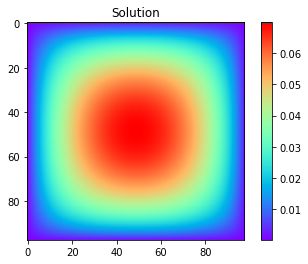

In [12]:
N=100
omega = 1

f=np.ones((N-2)*(N-2))
residuals = []

linop= genLinOp(eval_gpu, N, omega)
callback = lambda vec: residuals.append(np.linalg.norm(f - linop.matvec(vec)) / np.linalg.norm(f))

sol, info = cg(linop, f, callback=callback, maxiter=1000)

if len(residuals) > 50:
  residuals = residuals[:50] # Only plot the first 50 residuals

res_matrix = np.reshape(sol, ((N-2),(N-2)))

fig = plt.figure()
plt.title('Solution')
im =plt.imshow(res_matrix, cmap = 'rainbow')
cb = fig.colorbar(im)